# Тестирование двойственного алгоритма решения задачи минимизации максимального запаздывания

# What's new:
- Переработан алгоритм решения двойственной задачи, в качестве функции потерь $\varphi(C_{i_k}(\pi_k))$ используется $L_{max}(\pi_k)$, которая удовлетворяет требованию неубывания;
- Изменён метод генерации примеров;
- Предложена и протестирована версия алгоритма с ещё меньшим средним количеством точек ветвления, необходимых для поиска оптимального расписания.

### Импорты

In [120]:
import time
import pandas as pd
from IPython.display import clear_output
from scipy.stats import moment
import sys
import json
import random
import numpy as np
import matplotlib.pyplot as plt
from itertools import permutations
from scipy.optimize import curve_fit

### Класс "Расписание"

In [249]:
LAMBDA = 0.01
MU = 100
SIGMA = 40
VARK = 1

class Schedule:
    """
    A wrap around arrays of shape (n, 3), 
    where n is the number of jobs in the schedule
    and each job parameters are ordered as follows:
    r | p | d
    """
    array = None
    
    def enum(self):
        if len(self.array) > 0:
            a = np.append(self.array, np.ones((len(self.array), 1)), axis=1)
            for i, _ in enumerate(a):
                a[i, 3] += i
            self.array = a.astype(int)
    
    def __init__(self, array, Enumerate=False):
        """
        Arguments:
        - array: int or list/np.ndarray
        if int, the schedule is generated randomly and contains n elements
        if list/np.ndarray/etc., the array is directly transformed into schedule
        """
        if isinstance(array, int):
            rs = [0]
            for i in range(1, array):
                rs.append(rs[i-1] + random.expovariate(LAMBDA))
            ps = np.clip(np.random.normal(MU, SIGMA, size=(array,)), a_min=0, a_max=None)
            ds = [r + VARK*moment(ps, moment=2) for r in rs]
            self.array = np.array([rs, ps, ds]).T.astype(int)
            #print(self.array)
            
            #self.array = np.random.randint(1, 1000, size=(array, 3))
            # for non-negative time slack
            #self.array[:,2] = self.array[:,2] + self.array[:,1] + self.array[:,0]
            #print(self.array)
        else: self.array = np.copy(array)
        if Enumerate: self.enum()
    
    def show(self):
        print(" r  |  p  |  d  | num ")
        print(self.array)
        
    def sort(self, item=0):
        self.array = self.array[self.array[:,item].argsort()]
        
    def remove(self, B):
        idx = []
        for i, e in enumerate(np.isin(self.array, B)):
            if e.all():
                idx.append(i)
        self.array = np.delete(self.array, idx, axis=0)
    
    def pop(self, index=-1):
        e = self.array[index]
        self.array = np.delete(self.array, index, axis=0)
        return e
    
    def copy(self):
        return Schedule(np.copy(self.array))
    
    def insert(self, index, elem):
        self.array = np.insert(self.array, index, elem, axis=0)
        
    def length(self):
        return self.array.shape[0]
    
    def C(self, j=None):
        t = 0
        for task in self.array[:j]:
            if t < task[0]:
                t = task[0]
            t += task[1]
        return t
    
    def timeshift(self, tau):
        for i in range(self.length()):
            self.array[i,0] -= tau
            #self.array[i,2] -= tau
            
    def L_max(self, tau=0):
        if len(self.array) == 0:
            return float('inf')
        a = self.copy()
        a.timeshift(tau)
        return max([self.C(j+1) - a.array[j,2] for j in range(len(a.array))]) + tau
    
    def L(self, j, tau=0):
        a = self.copy()
        a.timeshift(tau)
        return self.C(j+1) - a.array[j, 2] + tau


### Алгоритм решения двойственной задачи

In [254]:
def dual(N, tau, B):
    pi_r = N.copy()
    pi_r.remove(B)
    pi_r.timeshift(tau)
    pi_r.sort()
    bestC = pi_r.L_max()
    bestI = 0
    if True:
        for k, e in enumerate(pi_r.array):
            pi_k = pi_r.copy()
            i_k = pi_k.pop(k)
            if pi_k.length() > 0:
                i_l = pi_k.pop(np.argmin(pi_k.array, axis=0)[0])
                pi_k.insert(pi_k.length(), i_k)
                pi_k.insert(0, i_l)
                C_k = pi_k.L_max()
                if C_k < bestC:
                    #print("CH!")
                    bestC = C_k
                    bestI = k
        return bestC + tau, bestI
        

### Класс "пример"
Содержит все параметры примера, указанные в статье: $N,\tau, \nu, \pi, B$, при чём $\nu$ автоматически вычисляется применением двойственного алгоритма к $N$

In [189]:
class Instance:
    
    def __init__(self, N, tau, pi=Schedule([]), B=[]):
        """
        Arguments:
        - N - Schedule object
        - tau - int or (possibly) float
        - pi - Schedule object
        - B - list
        """
        self.N = N.copy()
        self.tau = tau
        self.nu = dual(N, tau, B)[0]
        self.pi = pi.copy()
        self.B = B.copy()
        
    def best_job(self):
        N1 = self.N.copy()
        N1.remove(self.B)
        if len(N1.array) == 0:
            return
        a = N1.array[N1.array[:,0] <= self.tau]
        if len(a) == 0:
            self.tau = np.min(N1.array[:,0], axis=0)
            a = N1.array[N1.array[:,0] <= self.tau]
        f = min(a, key=lambda x: x[2])
        return f

### Алгоритм решения задачи $1|r_j|L_{max}$

In [298]:
# timeout parameter sets maximum calculation time limit in seconds for one schedule
timeout = 120

def main(N, tau=0):
    tb = time.time()
    c = 0
    bestPi = Schedule([])    
    instances = [Instance(N, tau)]
    while len(instances) > 0:
        ti = time.time()
        if ti - tb > timeout:
            return Schedule([]), -1
        index, instance = min(
            enumerate(instances),
            key=lambda x: max(x[1].nu, x[1].pi.L_max()) - x[1].pi.length()/N.length()/10
        )
        f = instance.best_job()
        instances.pop(index)
        if f is not None:
            
            N1 = instance.N.copy()
            N1.remove(f)
            tau1 = max(f[0], instance.tau) + f[1]
            B1 = []
            a1 = np.copy(instance.pi.array)
            if len(a1) == 0:
                a1 = np.copy([f,])
            else:
                a1 = np.append(a1, [f,], axis=0)
            pi1 = Schedule(a1)
            i1 = Instance(N1, tau1, pi1, B1)
            
            N2 = instance.N
            tau2 = instance.tau
            if len(instance.B) == 0:
                B2 = np.copy([f,])
            else:
                B2 = np.append(instance.B, [f,], axis=0)
            pi2 = instance.pi
            i2 = Instance(N2, tau2, pi2, B2)

            instances += [i1, i2]
            
            c += 1
            #pi1.show()
            if pi1.length() == N.length():
                
                if pi1.L_max(tau) < bestPi.L_max(tau):
                    bestPi = pi1.copy()
            instances = [i for i in instances
                         if i.nu < bestPi.L_max(tau)]

    return bestPi, c

### Алгоритм перебора *всех* возможных вариантов

In [191]:
def bruteforce(S, tau=0):
    N = np.copy(S.array)
    best_L = Schedule(N).L_max(tau)
    best_S = N
    for p in permutations(N):
        L = Schedule(p).L_max(tau)
        if L < best_L:
            best_L = L
            best_S = p
    return Schedule(best_S)

### Проверка корректности работы алгоритма
Для расписаний размерности 5: генерация множества из 10000 требований; решение задачи алгоритмом и методом полного перебора, сравнение полученных значений $min(L_{max})$

In [299]:
bL, mL = 0, 0
counter = 0
while bL == mL:
    s = Schedule(5)
    b = bruteforce(s)
    m, c = main(s)
    if len(m.array) != 0: # an empty array is returned if the time limit is exceeded
        bL = b.L_max()
        mL = m.L_max()
        counter += 1
    if counter % 100 == 0: print('\r', counter, end='\t \t \t')
    if counter == 10000:
        print("100% correct!")
        break

 10000	 	 	100% correct!


In [289]:
m.array

array([[   0,  191, 1782],
       [ 180,   75, 1963],
       [ 214,   80, 1996],
       [ 622,  136, 2405],
       [ 711,  113, 2494]])

### Построение графиков

In [ ]:
for size in range(4, 9):
    results = {}
    for i in range(100000):
        s = Schedule(size)
        bp, c = main(s)
        if c not in results.keys():
            results[c] = 1
        else:
            results[c] += 1
        if (i+1) % 200 == 0:
            plt.title("Количество точек ветвления для %s примеров размерности %s" % (i+1, size))
            plt.xlabel("Счётчик")
            plt.ylabel("Частота")
            plt.grid(axis='y')
            plt.bar(results.keys(), results.values(), width=1)
            plt.show()
            clear_output(wait=True)
    with open('freq%s.json' % size, 'w') as f:
        json.dump(results, f)
    plt.savefig('freq%s.png' % size, dpi=300)

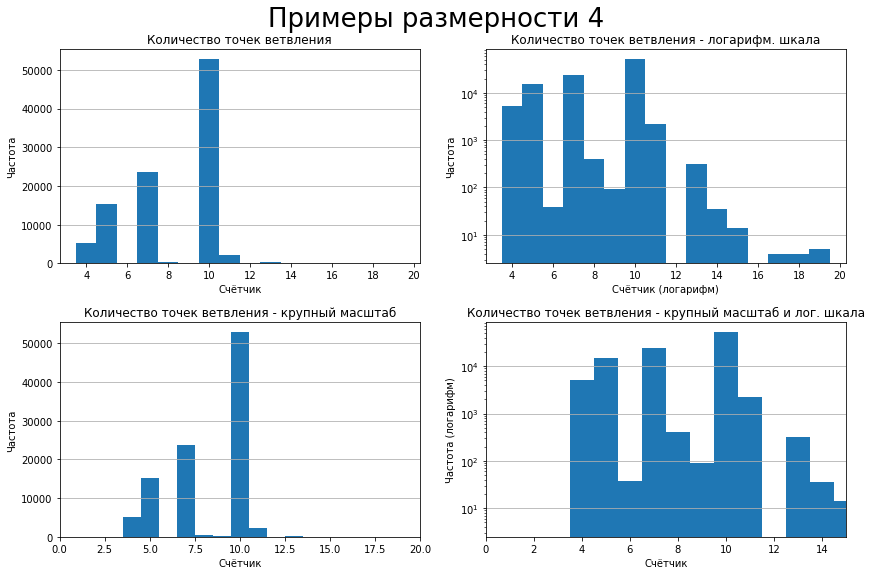

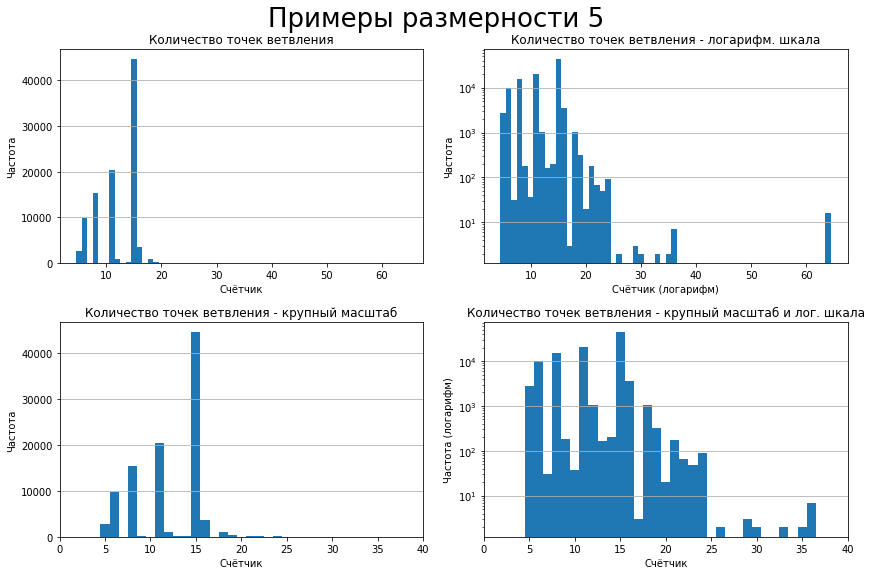

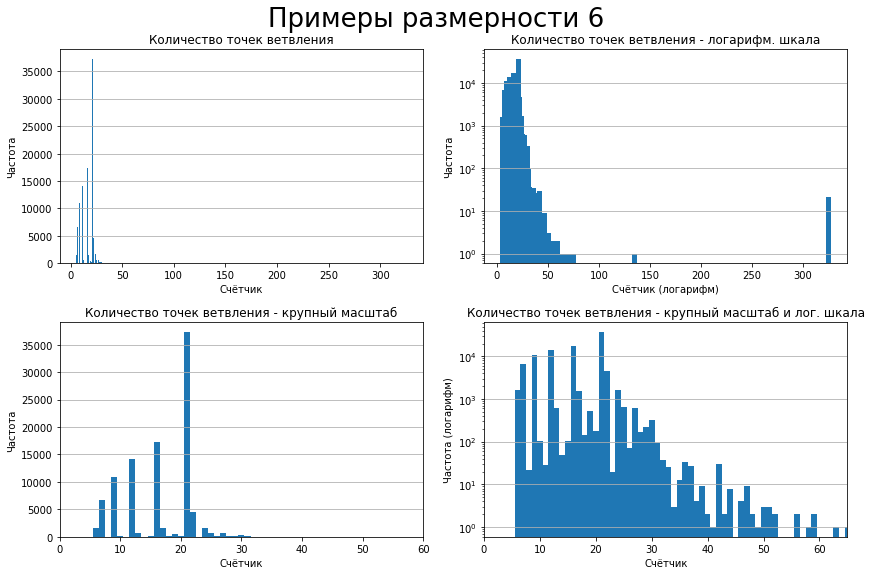

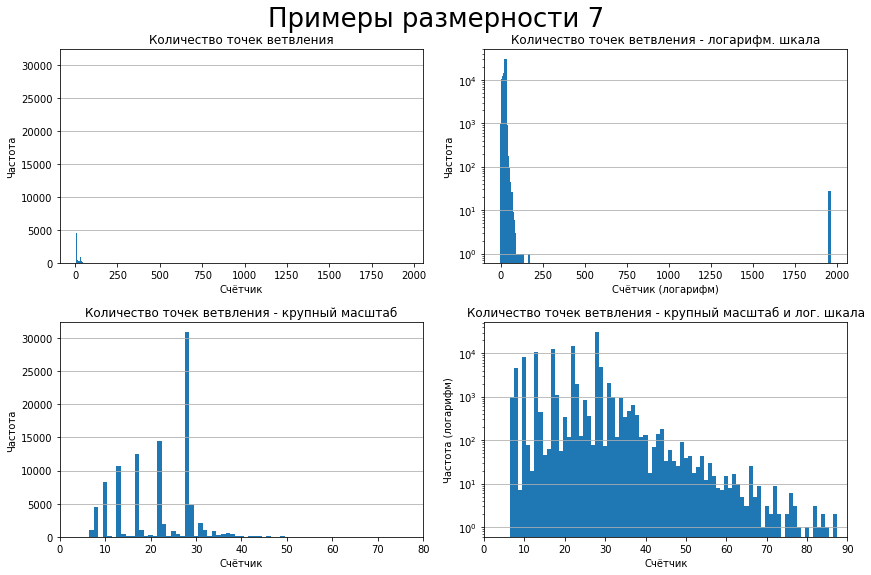

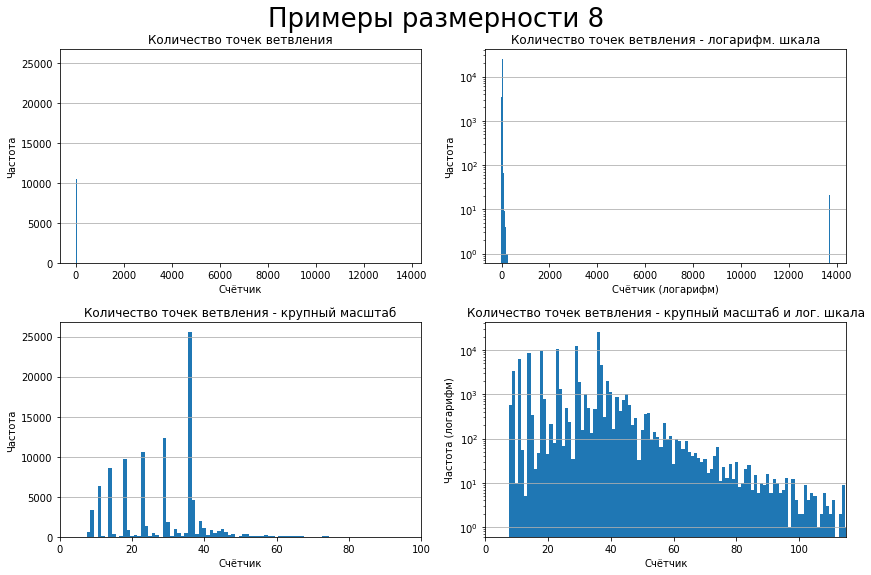

In [278]:
for i in range(4, 9):
    with open("freq%s.json" % i, 'r') as f:
        d = json.load(f)
        x = list(map(int, d.keys()))
        y = list(map(int, d.values()))
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), constrained_layout=True)
        fig.suptitle("Примеры размерности %s" % i, fontsize=26)
        l_width = 1
        if i > 5: l_width = (i-5.5)*10
        axes[0, 0].bar(x, y, width=1)
        axes[0, 0].set_title("Количество точек ветвления")
        axes[0, 0].set_xlabel("Счётчик")
        axes[0, 0].set_ylabel("Частота")
        axes[0, 0].grid(axis='y')
        axes[0, 1].bar(x, y, log=True, width=l_width)
        axes[0, 1].set_title("Количество точек ветвления - логарифм. шкала")
        axes[0, 1].set_xlabel("Счётчик (логарифм)")
        axes[0, 1].set_ylabel("Частота")
        axes[0, 1].grid(axis='y')
        axes[1, 0].set_title("Количество точек ветвления - крупный масштаб")
        axes[1, 0].set_xlabel("Счётчик")
        axes[1, 0].set_ylabel("Частота")
        axes[1, 0].grid(axis='y')
        axes[1, 0].set_xlim(right=(i-3)*20)
        axes[1, 0].bar(x, y, width=1)
        axes[1, 1].set_title("Количество точек ветвления - крупный масштаб и лог. шкала")
        axes[1, 1].set_xlabel("Счётчик")
        axes[1, 1].set_ylabel("Частота (логарифм)")
        axes[1, 1].grid(axis='y')
        axes[1, 1].set_xlim(right=(i-3)*25 - 10)
        axes[1, 1].bar(x, y, log=True, width=1)

# Модифицированный алгоритм
- В качестве начального значения $\pi^*$ задаётся не $\pi^* = \emptyset$, а $\pi^* = \pi_r$ - расписание, составленное сортировкой всех требований по возрастанию времени поступления $r_j$.
- При поиске примеров предпочтение отдаётся тем, у которых расписание $\pi$ длиннее - то есть уже отсортировано больше требований. 

In [300]:
# timeout parameter sets maximum calculation time limit in seconds for one schedule
timeout = 120

def main(N, tau=0):
    tb = time.time()
    c = 0
    bestPi = Schedule(N.array)    
    instances = [Instance(N, tau)]
    while len(instances) > 0:
        ti = time.time()
        if ti - tb > timeout:
            return Schedule([]), -1
        index, instance = min(
            enumerate(instances),
            key=lambda x: max(x[1].nu, x[1].pi.L_max()) - x[1].pi.length()/N.length()/10
        )
        f = instance.best_job()
        instances.pop(index)
        if f is not None:
            
            N1 = instance.N.copy()
            N1.remove(f)
            tau1 = max(f[0], instance.tau) + f[1]
            B1 = []
            a1 = np.copy(instance.pi.array)
            if len(a1) == 0:
                a1 = np.copy([f,])
            else:
                a1 = np.append(a1, [f,], axis=0)
            pi1 = Schedule(a1)
            i1 = Instance(N1, tau1, pi1, B1)
            
            N2 = instance.N
            tau2 = instance.tau
            if len(instance.B) == 0:
                B2 = np.copy([f,])
            else:
                B2 = np.append(instance.B, [f,], axis=0)
            pi2 = instance.pi
            i2 = Instance(N2, tau2, pi2, B2)

            instances += [i1, i2]
            
            c += 1
            #pi1.show()
            if pi1.length() == N.length():
                
                if pi1.L_max(tau) < bestPi.L_max(tau):
                    bestPi = pi1.copy()
            instances = [i for i in instances
                         if i.nu < bestPi.L_max(tau)]

    return bestPi, c

### Проверка корректности работы алгоритма
Для расписаний размерности 5: генерация множества из 10000 требований; решение задачи алгоритмом и методом полного перебора, сравнение полученных значений $min(L_{max})$

In [295]:
bL, mL = 0, 0
counter = 0
while bL == mL:
    s = Schedule(5)
    b = bruteforce(s)
    m, c = main(s)
    if m.array is not []: # an empty array is returned if time limit is exceeded
        bL = b.L_max()
        mL = m.L_max()
        counter += 1
    if counter % 100 == 0: print('\r', counter, end='\t \t \t')
    if counter == 10000:
        print("100% correct!")
        break

 10000	 	 	100% correct!


### Построение графиков

In [301]:
for size in range(4, 9):
    results = {}
    for i in range(100000):
        s = Schedule(size)
        bp, c = main(s)
        if c not in results.keys():
            results[c] = 1
        else:
            results[c] += 1
        if (i+1) % 200 == 0:
            plt.title("Количество точек ветвления для %s примеров размерности %s" % (i+1, size))
            plt.xlabel("Счётчик")
            plt.ylabel("Частота")
            plt.grid(axis='y')
            plt.bar(results.keys(), results.values(), width=1)
            plt.show()
            clear_output(wait=True)
    with open('freqn%s.json' % size, 'w') as f:
        json.dump(results, f)
    #plt.savefig('freqn%s.png' % size, dpi=300)

<Figure size 432x288 with 0 Axes>

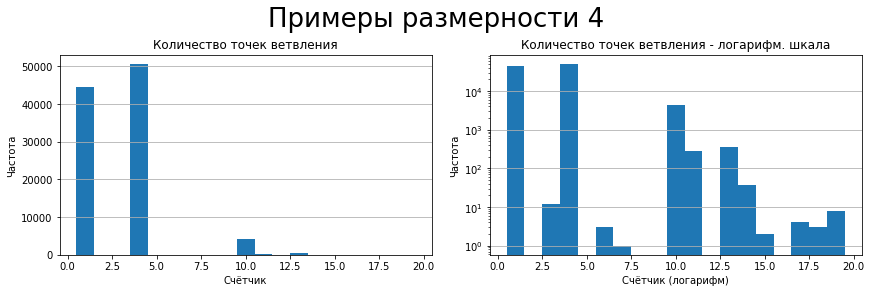

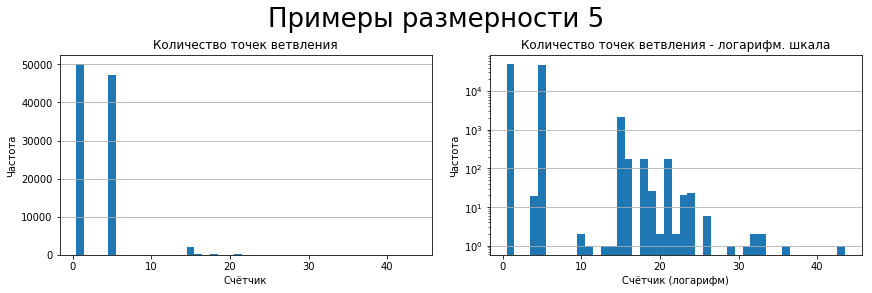

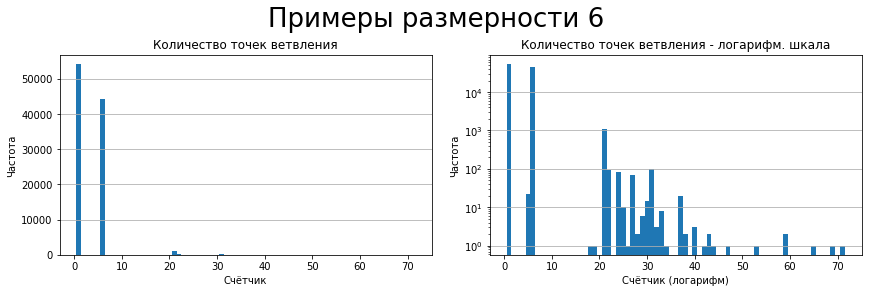

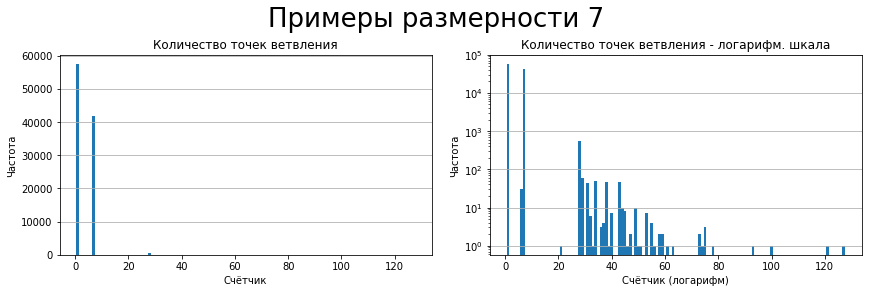

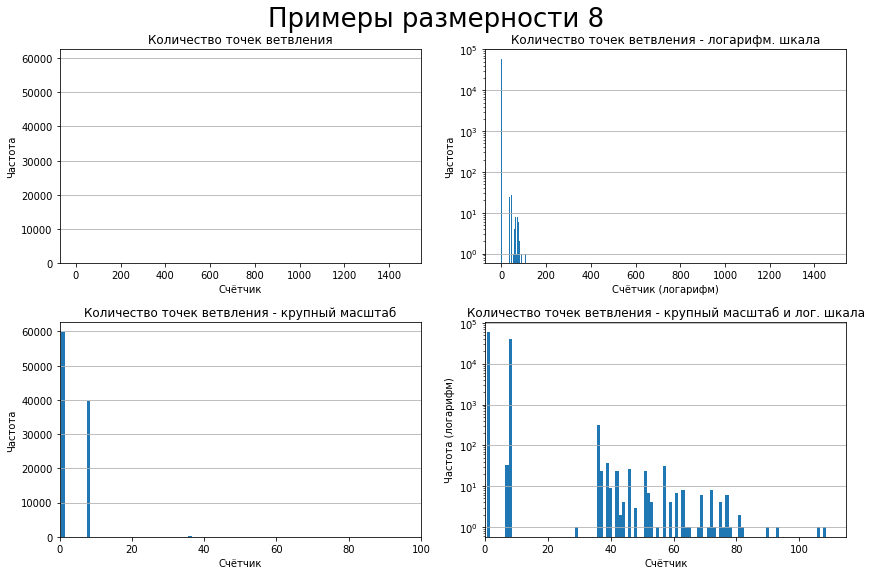

In [308]:
for i in range(4, 9):
    with open("freqn%s.json" % i, 'r') as f:
        d = json.load(f)
        x = list(map(int, d.keys()))
        y = list(map(int, d.values()))
        if i == 8:
            nrows = 2
            figsize=(12, 8)
        else:
            nrows = 1
            figsize=(12, 4)
        fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=figsize, constrained_layout=True, squeeze=False)
        fig.suptitle("Примеры размерности %s" % i, fontsize=26)
        l_width = 1
        #if i > 5: l_width = (i-5.5)*10
        axes[0, 0].bar(x, y, width=1)
        axes[0, 0].set_title("Количество точек ветвления")
        axes[0, 0].set_xlabel("Счётчик")
        axes[0, 0].set_ylabel("Частота")
        axes[0, 0].grid(axis='y')
        axes[0, 1].bar(x, y, log=True, width=l_width)
        axes[0, 1].set_title("Количество точек ветвления - логарифм. шкала")
        axes[0, 1].set_xlabel("Счётчик (логарифм)")
        axes[0, 1].set_ylabel("Частота")
        axes[0, 1].grid(axis='y')
        if i == 8:
            axes[1, 0].set_title("Количество точек ветвления - крупный масштаб")
            axes[1, 0].set_xlabel("Счётчик")
            axes[1, 0].set_ylabel("Частота")
            axes[1, 0].grid(axis='y')
            axes[1, 0].set_xlim(right=(i-3)*20)
            axes[1, 0].bar(x, y, width=1)
            axes[1, 1].set_title("Количество точек ветвления - крупный масштаб и лог. шкала")
            axes[1, 1].set_xlabel("Счётчик")
            axes[1, 1].set_ylabel("Частота (логарифм)")
            axes[1, 1].grid(axis='y')
            axes[1, 1].set_xlim(right=(i-3)*25 - 10)
            axes[1, 1].bar(x, y, log=True, width=1)

# Тестирование

### Оценка сложности алгоритма
Метрика - количество узлов ветвления

In [336]:
results = dict()
for n in range(3, 15, 1):
    results[n] = []
    for i in range(1):
        print('\r', len(results[n]), end='')
        t = 0
        s = Schedule(n)
        timing = %timeit -q -o -r 5 main(s, t)
        results[n].append(np.mean(timing.timings))
    print(" --", n, "tasks")
    
    json.dump(results, open('results_timingsnew.json', 'w'))

 0 -- 3 tasks
 0 -- 4 tasks
 0 -- 5 tasks
 0 -- 6 tasks
 0 -- 7 tasks
 0 -- 8 tasks
 0

KeyboardInterrupt: 

In [266]:
results = dict()
timings = dict()
for n in range(3, 10, 1):
    results[n] = []
    timings[n] = []
    for i in range(100):
        print('\r', len(results[n]), end='')
        s = Schedule(n)
        #timing = %timeit -q -o -r 5 main(s, t)
        ts = time.time()
        res, c = main(s)
        te = time.time()
        if c != -1:
            results[n].append(c)
            timings[n].append(te - ts)
    print(" --", n, "tasks")
    
    with open('Nresults_new.json', 'w') as f: json.dump(results, f)
    with open('Ntimings_new.json', 'w') as f: json.dump(timings, f)

 99 -- 3 tasks
 99 -- 4 tasks
 99 -- 5 tasks
 99 -- 6 tasks
 99 -- 7 tasks
 99 -- 8 tasks
 99 -- 9 tasks


In [170]:
results = dict()
for n in range(3, 26, 1):
    results[n] = []
    for i in range(100):
        print('\r', len(results[n]), end='')
        t = 0
        s = Schedule(n)
        c = %timeit -q -o -n 1 -r 1 main(s, t)
        #res, c = main(s)
        results[n].append(c.timings[-1])
    print(" --", n, "tasks")
    
    json.dump(results, open('resultsTiming_new.json', 'w'))

 99 -- 3 tasks
 99 -- 4 tasks
 37

KeyboardInterrupt: 

### Примеры малой размерности

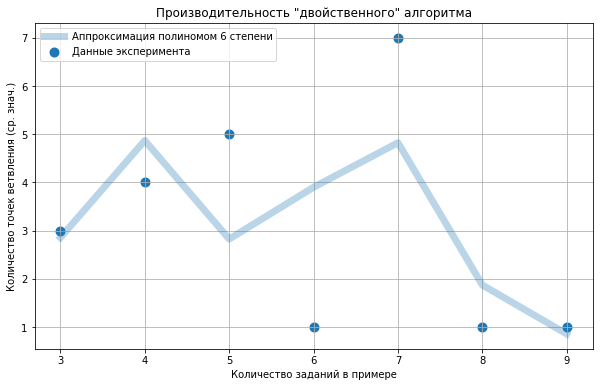

In [269]:

#with open('timings_new.json', 'r') as f: timings = json.load(f)
x = []
y = []
#yf = []
for k in results.keys():
    y.append(np.median(results[k]))
    x.append(k)
    #yf.append(np.math.factorial(k))
z = [approx(x,y,i) for i in range(6)]

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, title='Производительность "двойственного" алгоритма')
ax.grid()
ax.scatter(x, y, linewidth=4, label="Данные эксперимента")
ax.set_xlabel("Количество заданий в примере")
ax.set_ylabel("Количество точек ветвления (ср. знач.)")
i = 5
ax.plot(x, z[i](list(map(int, x))),
        label='Аппроксимация полиномом %s степени' % (i+1),
        linewidth=7,
        alpha=0.3)
ax.legend()

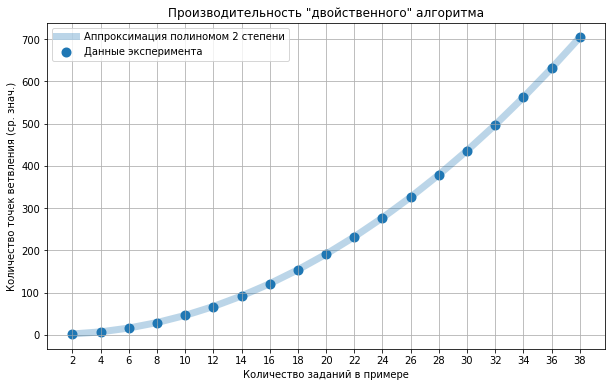

In [0]:
x = []
y = []
#yf = []
for k in results2.keys():
    y.append(np.median(results2[k]))
    x.append(k)
    #yf.append(np.math.factorial(k))

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, title='Производительность "двойственного" алгоритма')
ax.grid()
ax.scatter(x, y, linewidth=4, label="Данные эксперимента")
ax.set_xlabel("Количество заданий в примере")
ax.set_ylabel("Количество точек ветвления (ср. знач.)")
i = 1
ax.plot(x, z[i](list(map(int, x))),
        label='Аппроксимация полиномом %s степени' % (i+1),
        linewidth=7,
        alpha=0.3)
ax.legend()

### Примеры большой размерности

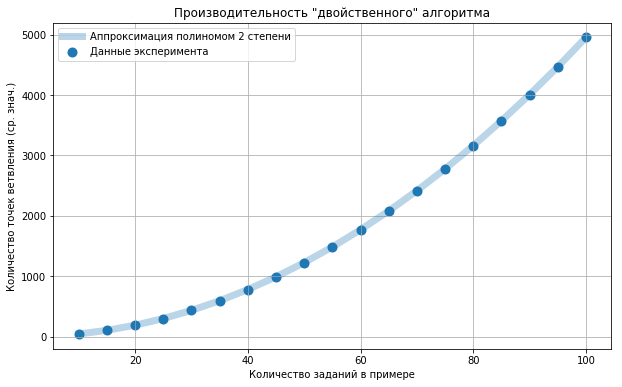

In [0]:
x = []
y = []
for k in results.keys():
    y.append(np.median(results[k]))
    x.append(k)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.grid()
ax.scatter(x, y, linewidth=4, label="Данные эксперимента")
ax.set_xlabel("Количество заданий в примере")
ax.set_ylabel("Время выполнения (ср. знач.), с")
i = 1
ax.plot(x, z[1](x), label='Аппроксимация полиномом %s степени' % (i+1),
        linewidth=7,
        alpha=0.3)
ax.legend()

## Проверка быстродействия
Метрика - время выполнения алгоритма

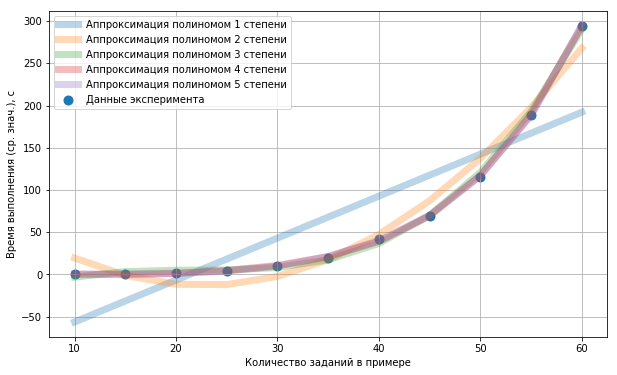

In [50]:
x = list(results.keys())[:-1]
y = list(map(lambda x: x[0], list(results.values())[:-1]))
z = [approx(x, y, i) for i in range(1, 6)]

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.grid()
ax.scatter(x, y, linewidth=4, label="Данные эксперимента")
ax.set_xlabel("Количество заданий в примере")
ax.set_ylabel("Время выполнения (ср. знач.), с")
for i in range(5):
    ax.plot(x, z[i](x), label='Аппроксимация полиномом %s степени' % (i+1),
        linewidth=7,
        alpha=0.3)
ax.legend()

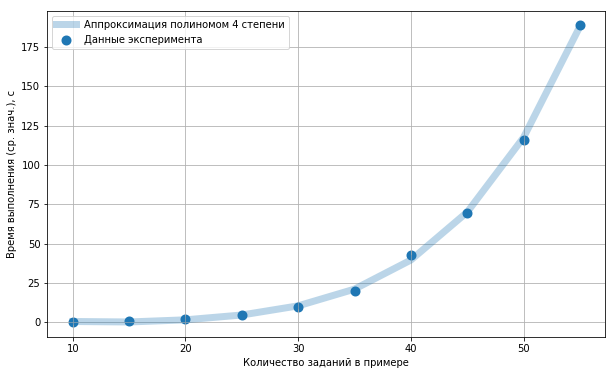

In [11]:
i = 4
x = list(map(int, list(results.keys())[:-1]))
y = list(map(lambda x: x[0], list(results.values())[:-1]))
z = approx(x, y, i)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.grid()
ax.scatter(x, y, linewidth=4, label="Данные эксперимента")
ax.set_xlabel("Количество заданий в примере")
ax.set_ylabel("Время выполнения (ср. знач.), с")
ax.plot(x, z(x), label='Аппроксимация полиномом %s степени' % (i),
        linewidth=7,
        alpha=0.3)
ax.legend()

## Функция аппроксимации

In [21]:
def approx(x, y, i):
    """
    Parameters:
     - x - x values list
     - y - y values list
     - i - polynome power
    Returns:
     numpy poly1d function
    """
    return np.poly1d(np.polyfit(list(map(float, x)),
                                list(map(float, y)),
                                i))

In [427]:
results

{11: 105,
 15: 269,
 8: 78,
 6: 65,
 5: 19,
 18: 5,
 16: 23,
 12: 1,
 9: 2,
 23: 1,
 19: 1}